In [2]:
import ot
import torch
from torch import nn
from torch.nn import functional as F
import math
from base import *
from torch.distributions import Normal, MultivariateNormal, Independent

from torch.distributions.bernoulli import Bernoulli
import numpy as np
import solver

ModuleNotFoundError: No module named 'ot'

In [2]:
class Decoder(nn.Module):
    def __init__(self, in_channels, latent_dim,
                 activation, img_size=28, n_channels=None):
        super(Decoder, self).__init__()
        if n_channels is None:
            n_channels = [128, 64, 32]
        self.in_channels = in_channels
        self.activation = activation
        self.img_size = img_size
        self.n_channels = n_channels
                
        self.first_layer_width = math.ceil(img_size / (2 ** len(self.n_channels)))
        self.first_layer_size =  self.first_layer_width ** 2

        self.decoder_input = fc_block(latent_dim, self.n_channels[0] * self.first_layer_size, self.activation, False)
        
        modules = []
        for i in range(len(self.n_channels) - 1):
            if img_size == 28 and i == 0:
                modules.append(convt_block(self.n_channels[i], self.n_channels[i + 1], self.activation, False,
                                     kernel_size=3, stride=2, padding=1, output_padding=0))
            else:
                modules.append(convt_block(self.n_channels[i], self.n_channels[i + 1], self.activation, False,
                                     kernel_size=3, stride=2, padding=1, output_padding=1))
                
        self.decoder = nn.Sequential(*modules)
        self.final_layer = nn.Sequential(
            nn.ConvTranspose2d(self.n_channels[-1],
                               self.n_channels[-1],
                               kernel_size=3,
                               stride=2,
                               padding=1,
                               output_padding=1),
            self.activation,
            nn.Conv2d(self.n_channels[-1], out_channels=self.in_channels,
                      kernel_size=3, padding=1))

        
    def forward(self, z):
        result = self.decoder_input(z)
        result = result.view(-1, self.n_channels[0], self.first_layer_width, self.first_layer_width)
        result = self.decoder(result)
        logit = self.final_layer(result)
        return Bernoulli(logits = logit)


    
class NegEntropy(object):
    def __init__(self,epsilon):
        self.epsilon = epsilon
        
    def Omega(self, x):
        x = x.masked_fill(x <= 0., 1.)
        return (x*torch.log(x)).sum()

#         return (x*torch.log(x+1e-7)).sum()
        

    
class EOT(nn.Module):
    def __init__(self, epsilon, in_channels, latent_class, activation, img_size, n_channels=None):
        super(EOT, self).__init__()
        self.e = epsilon
        self.entropy = NegEntropy(epsilon)

        self.c_function = Decoder(in_channels, latent_class, activation, img_size, n_channels)
        self.z = F.one_hot(torch.arange(0, latent_class)).float()
        self.pz = torch.ones(latent_class)/latent_class

    def sinkhorn_scaling(self, x):
        self.px = torch.ones(len(x))/len(x)
        dist = self.c_function(self.z)
        x = x.repeat(1,len(self.z),1,1).unsqueeze(2)
        C = -dist.log_prob(x).sum([2,3,4])
        P = ot.sinkhorn(self.px, self.pz, C, self.e, method='sinkhorn_log')
        return P, C
        
    def forward(self, x):
        P, C = self.sinkhorn_scaling(x)
        kl = self.entropy.Omega(P)-self.entropy.Omega(self.px)-self.entropy.Omega(self.pz)
        return P, C, kl
    
    def loss(self, P, C, kl):
        return (P * C).sum() + kl

    
class EOT_sample(nn.Module):
    def __init__(self, n_sample, epsilon, in_channels, latent_dim, activation, img_size, n_channels=None):
        super(EOT_sample, self).__init__()
        self.e = epsilon
        self.entropy = NegEntropy(epsilon)
        self.c_function = Decoder(in_channels, latent_dim, activation, img_size, n_channels)

        mu = torch.zeros(n_sample,latent_dim)
        self.pz_true = Independent(Normal(loc=mu, scale=torch.ones_like(mu)),
                           reinterpreted_batch_ndims=1)
        
        self.pz = (torch.ones(n_sample)/n_sample).to(device)
        
    def sinkhorn_scaling(self, x):
        self.px = torch.ones(len(x))/len(x)
        self.z = self.pz_true.sample()
        dist = self.c_function(self.z)
        x = x.repeat(1,len(self.z),1,1).unsqueeze(2)
        C = -dist.log_prob(x).sum([2,3,4])
        P = ot.sinkhorn(self.px, self.pz, C, self.e, method='sinkhorn_log')
        return P, C
    
    def semi_dual_sgd(self,x):
        self.px = (torch.ones(len(x))/len(x)).to(device)
        self.z = self.pz_true.sample().to(device)
        dist = self.c_function(self.z)
        x = x.repeat(1,len(self.z),1,1).unsqueeze(2)
        C = -dist.log_prob(x).sum([2,3,4])
        P, u, v = solver.solve_semi_dual_entropic(self.px, self.pz, C, reg=1, numItermax=1000)
        return P, C
        
    def forward(self, x):
        P, C = self.semi_dual_sgd(x)
        kl = self.entropy.Omega(P)-self.entropy.Omega(self.px)-self.entropy.Omega(self.pz)
        return P, C, kl
    
    def loss(self, P, C, kl):
        return (P * C).sum() + kl        
        
class EOT_semi_dual(nn.Module):
    def __init__(self, n_data, n_sample, epsilon, in_channels, latent_dim, activation, img_size, n_channels=None):
        super(EOT_semi_dual, self).__init__()
        self.n_data = n_data
        self.n_sample = n_sample
        
        self.e = epsilon
        self.entropy = NegEntropy(epsilon)
        self.c_function = Decoder(in_channels, latent_dim, activation, img_size, n_channels)

        mu = torch.zeros(1,latent_dim)
        self.alpha_true = Independent(Normal(loc=mu, scale=torch.ones_like(mu)),
                           reinterpreted_batch_ndims=1)
        
        self.beta = torch.ones(self.n_data)/self.n_data
        self.alpha = torch.ones(n_sample)/n_sample
        
    def c_transform(self, x, z):
        dist = self.c_function(z)
        x = x.unsqueeze(2)
        C = -dist.log_prob(x).sum([2,3,4])
        lse = - self.e * (torch.logsumexp(self.v - C)-torch.log(self.n_data))
        return lse
        
    def g_eps(self, x):
        z = self.alpha_true.sample()
        v_beta = self.v.dot(self.beta)
        lse = self.c_transform(x,z)
        return v_beta - lse

        
    def forward(self, x):
        P, C = self.sinkhorn_scaling(x)
        kl = self.entropy.Omega(P)-self.entropy.Omega(self.px)-self.entropy.Omega(self.pz)
        return P, C, kl
    
    def loss(self, P, C, kl):
        return (P * C).sum() + kl  

In [3]:
from torchvision import transforms
import torchvision
import matplotlib.pyplot as plt

class Binarize(object):
    """ This class introduces a binarization transformation
    """
    def __call__(self, pic):
        return torch.Tensor(pic.size()).bernoulli_(pic)

    def __repr__(self):
        return self.__class__.__name__ + '()'
    

def _data_transforms_mnist():
    """Get data transforms for mnist."""
    train_transform = transforms.Compose([
        transforms.ToTensor(),
        Binarize(),
    ])

    valid_transform = transforms.Compose([
        transforms.ToTensor(),
        Binarize(),

    ])

    return train_transform, valid_transform

def get_loaders(args):

    if args.dataset == 'MNIST':
        train_transform, valid_transform = _data_transforms_mnist()
        train_data = torchvision.datasets.MNIST(root=args.data, train=True, download=True, transform=train_transform)
        test_data = torchvision.datasets.MNIST(root=args.data, train=False, download=True, transform=valid_transform)

#     idx = train_data.targets <= 2
#     train_data.targets = train_data.targets[idx]
#     train_data.data = train_data.data[idx]
    
#     subset = list(range(0, 300))
    
#     train_data= torch.utils.data.Subset(train_data, subset)
    
    train_queue = torch.utils.data.DataLoader(train_data, batch_size=args.batch_size,shuffle=True,
                                  pin_memory=True)

    test_queue = torch.utils.data.DataLoader(test_data, batch_size=10000, shuffle=False, pin_memory=True)
    
    return train_queue, test_queue

class config(object):
    def __init__(self, dataset, batch_size):
        self.dataset = dataset
        self.batch_size = batch_size
        self.data = './'
        
args = config('MNIST',300)

In [4]:
actif='lrelu'
cuda = torch.cuda.is_available()
device = torch.device("cuda" if cuda else "cpu")

activations_list = {
    'softplus': nn.Softplus(),
    'lrelu': nn.LeakyReLU(),
    'relu': nn.ReLU()
}
activFun = activations_list[actif]
train_loader, ts = get_loaders(args)

img_size = 28
epsilon = 1
in_channels =1
latent_class = 2
epochs = 2
n_samples = 600

In [5]:
model = EOT_sample(n_samples, epsilon, in_channels, latent_class, activFun, img_size)
model.cuda()
optimizer = torch.optim.Adam(model.parameters(), lr=3e-4)


In [7]:
for epoch in range(1, epochs + 1):
    loss_sum = 0
    for batch_idx, (data, target) in enumerate(train_loader):
        data = data.to(device)
        print("1:", torch.cuda.memory_allocated())
        optimizer.zero_grad()
        P, C, kl = model(data)
        loss = model.loss(P, C, kl)
        print("2:", torch.cuda.memory_allocated())
        loss.backward()
        print("3:", torch.cuda.max_memory_allocated())
        optimizer.step()
        with torch.no_grad():
            loss_sum += loss.item()
    print(f"Epoch: {epoch}, Loss: {loss_sum/len(train_loader)}")


1: 1377280
2: 2193040384
3: 3565556736
1: 4126720
2: 2194341376
3: 3568299520
1: 4126720


KeyboardInterrupt: 

In [49]:
with torch.no_grad():
    dist = model.c_function(model.z)

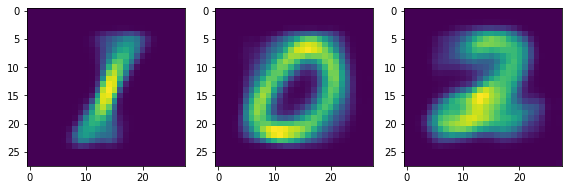

In [376]:
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(8, 4))
img = dist.mean.numpy().transpose(0,2,3,1)
n = 0
for ax in axs.flat:
    ax.imshow(img[n])
    n=n+1

plt.tight_layout()
plt.show()

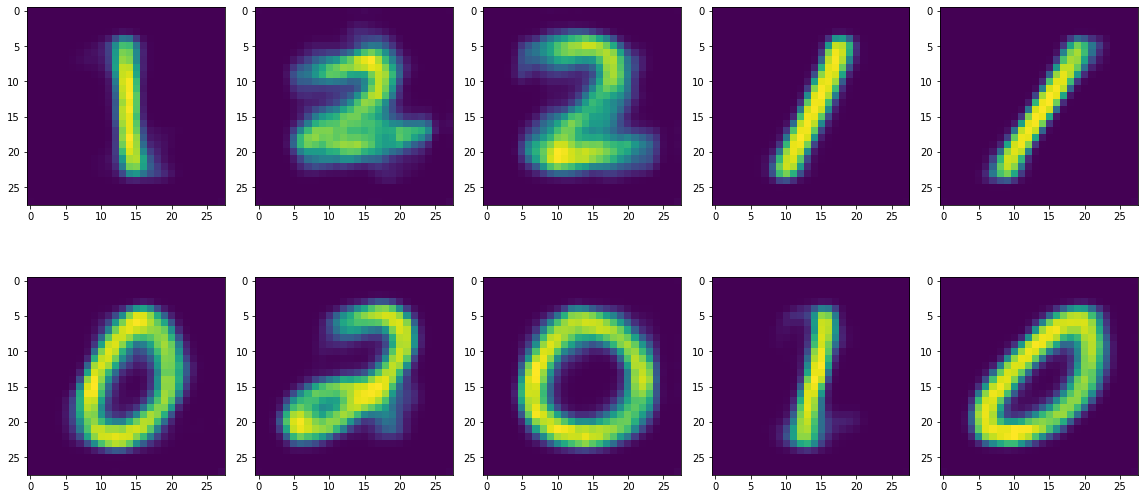

In [384]:
fig, axs = plt.subplots(nrows=2, ncols=5, figsize=(16, 8))
img = dist.mean.numpy().transpose(0,2,3,1)
n = 0
for ax in axs.flat:
    ax.imshow(img[n])
    n=n+1

plt.tight_layout()
plt.show()

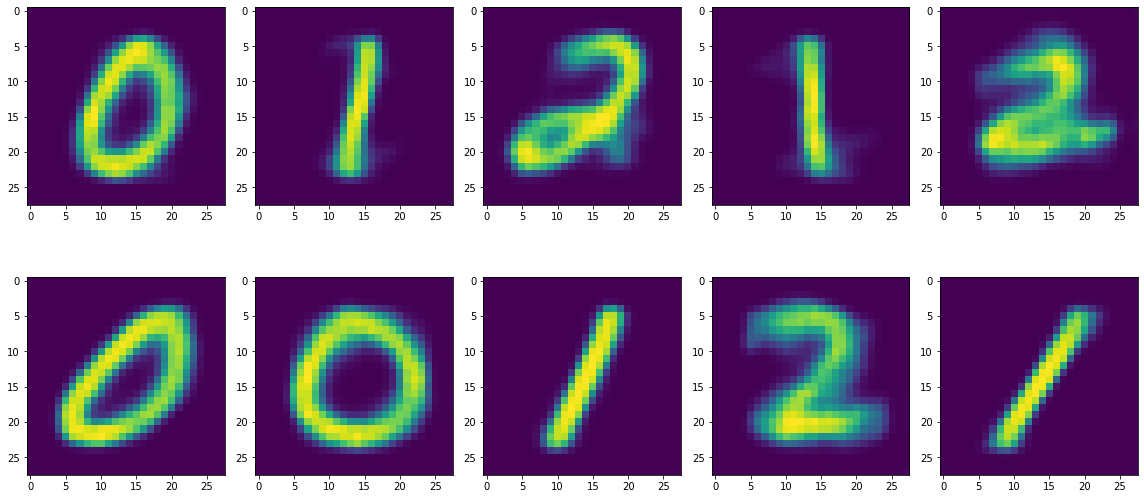

In [9]:
fig, axs = plt.subplots(nrows=2, ncols=5, figsize=(16, 8))
img = dist.mean.numpy().transpose(0,2,3,1)
n = 0
for ax in axs.flat:
    ax.imshow(img[n])
    n=n+1

plt.tight_layout()
plt.show()

In [ ]:
def gradient_SAG(v_eps,epsilon,n_target, n_source, X_source,X_target,nu,idx,p):
    expv = np.zeros(n_target)
    while np.sum(expv) == 0:
        z = np.max(v_eps-np.sum(abs(X_target-X_source[idx,:])**p,axis=1)/epsilon)
        expv = nu * np.exp(v_eps-np.sum(abs(X_target-X_source[idx,:])**p,axis=1)/epsilon - z)
        if np.sum(expv) == 0:
            print "simulate again"
    pi = expv/np.sum(expv)
    grad = - nu + pi
    return grad

def gradient(v_eps,epsilon,n_target,rho_list_source,X_target,nu):
    expv = np.zeros(n_target)
    while np.sum(expv) == 0:
        Y = sample_rho(rho_list_source)
        z = np.max(v_eps-np.sum((X_target-Y)**2,axis=1)/epsilon)
        expv = nu * np.exp(v_eps-np.sum((X_target-Y)**2,axis=1)/epsilon - z)
        #if np.sum(expv) == 0:
        #print "simulate again"
    pi = expv/np.sum(expv)
    grad = - nu + pi
    return grad

In [78]:
with torch.no_grad():
    P, C, kl = model(data)
    z = model.z
z_ = z[P.argmax(axis=1)]

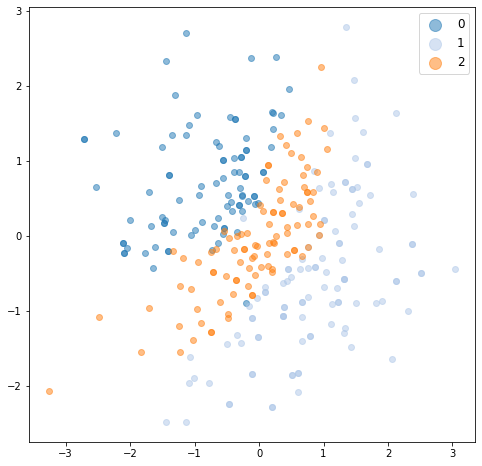

In [72]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import cm

cmap = cm.get_cmap('tab20')
fig, ax = plt.subplots(figsize=(8,8))
num_categories = 3
for lab in range(num_categories):
    indices = target==lab
    ax.scatter(z_[indices,0],z_[indices,1], c=np.array(cmap(lab)).reshape(1,4), label = lab ,alpha=0.5)
ax.legend(fontsize='large', markerscale=2)
plt.show()

# n_samples = 300

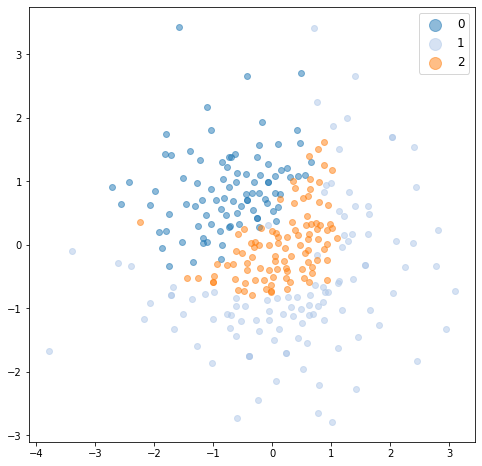

In [79]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import cm

cmap = cm.get_cmap('tab20')
fig, ax = plt.subplots(figsize=(8,8))
num_categories = 3
for lab in range(num_categories):
    indices = target==lab
    ax.scatter(z_[indices,0],z_[indices,1], c=np.array(cmap(lab)).reshape(1,4), label = lab ,alpha=0.5)
ax.legend(fontsize='large', markerscale=2)
plt.show()

# n_samples = 600

In [71]:
z_ = z[P.argmax(axis=1)]

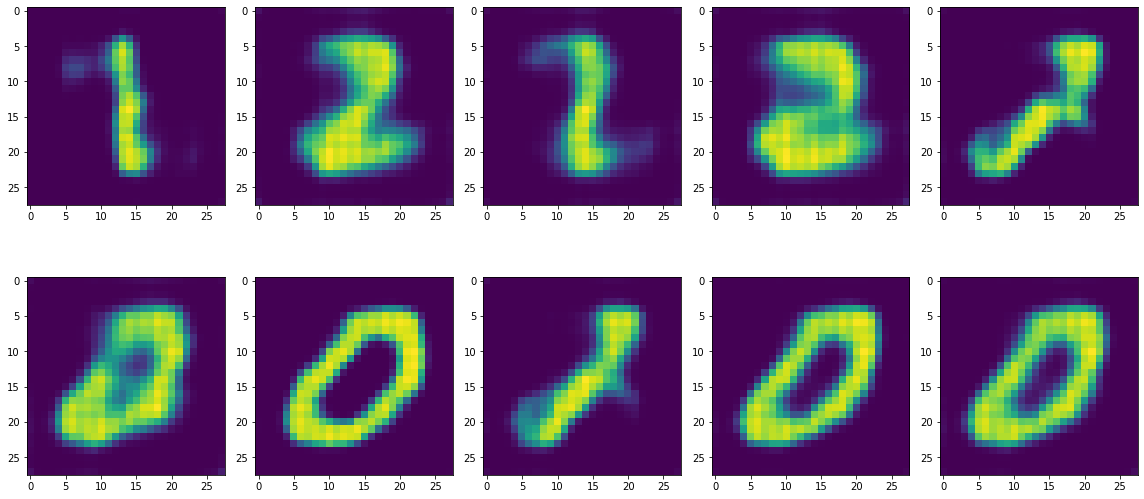

In [73]:
with torch.no_grad():
    dist = model.c_function(model.z)
fig, axs = plt.subplots(nrows=2, ncols=5, figsize=(16, 8))
img = dist.mean.numpy().transpose(0,2,3,1)[10:20]
n = 0
for ax in axs.flat:
    ax.imshow(img[n])
    n=n+1

plt.tight_layout()
plt.show()

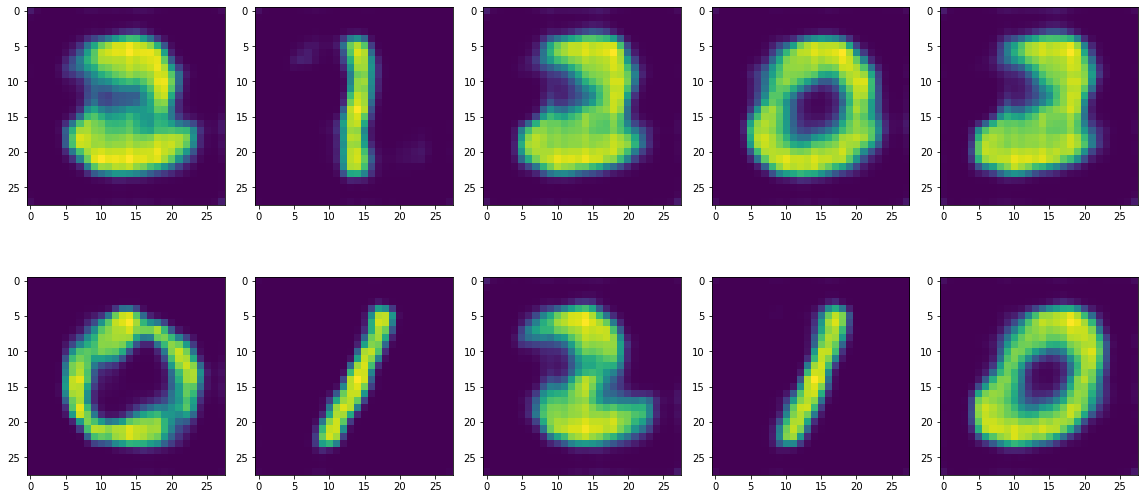

In [82]:
with torch.no_grad():
    dist = model.c_function(model.z)
fig, axs = plt.subplots(nrows=2, ncols=5, figsize=(16, 8))
img = dist.mean.numpy().transpose(0,2,3,1)[10:20]
n = 0
for ax in axs.flat:
    ax.imshow(img[n])
    n=n+1

plt.tight_layout()
plt.show()

In [22]:
%load_ext autoreload
%autoreload 2
import torch
import solver


In [2]:
M = torch.rand(30,100)
v = torch.zeros(100)
un_beta = torch.rand(100)
beta = un_beta/un_beta.sum()

In [43]:
import numpy as np
import ot
np.random.seed(0)
n_source = 7
n_target = 4
a = ot.utils.unif(n_source)
b = ot.utils.unif(n_target)
X_source = np.random.randn(n_source, 2)
Y_target = np.random.randn(n_target, 2)
M = ot.dist(X_source, Y_target)
pi_z= ot.stochastic.solve_semi_dual_entropic(a, b, M, reg=1, method="ASGD", numItermax=3000000)


In [37]:
a = torch.tensor(a)
b = torch.tensor(b)
M = torch.tensor(M)

In [38]:
pi, u, v = solver.solve_semi_dual_entropic(a, b, M, reg=1, numItermax=300000)

In [44]:
pi_z - pi.numpy()

array([[ 6.81429844e-05, -5.17970422e-05, -1.64029974e-05,
         5.70552024e-08],
       [-2.82995365e-05, -4.27135748e-05, -4.97233585e-06,
         7.59854472e-05],
       [ 1.17126144e-05,  7.70020164e-06, -1.94146708e-05,
         1.85477334e-09],
       [ 7.32260966e-05, -1.28739582e-05, -6.57979120e-05,
         5.44577358e-06],
       [-8.45441971e-05, -8.81728601e-06, -1.31397214e-04,
         2.24758697e-04],
       [-1.86050716e-04, -1.05924120e-05, -2.27156566e-05,
         2.19358784e-04],
       [ 9.28260250e-05, -2.52391147e-05, -9.82116335e-05,
         3.06247232e-05]])

In [45]:
pi_z

array([[2.56310095e-02, 9.95651168e-02, 1.76566435e-02, 4.37311943e-06],
       [1.21612484e-01, 1.24865531e-02, 1.29801712e-03, 7.46008897e-03],
       [3.57305600e-03, 7.61153966e-02, 6.31685545e-02, 1.35783656e-07],
       [2.62193480e-02, 3.33874078e-02, 8.28371902e-02, 4.13196834e-04],
       [9.76422135e-03, 7.42602750e-04, 1.06940953e-02, 1.21656223e-01],
       [2.14917312e-02, 8.92235669e-04, 1.84903096e-03, 1.18624145e-01],
       [4.16307599e-02, 2.65543914e-02, 7.22457704e-02, 2.42622118e-03]])

In [46]:
pi

tensor([[2.5563e-02, 9.9617e-02, 1.7673e-02, 4.3161e-06],
        [1.2164e-01, 1.2529e-02, 1.3030e-03, 7.3841e-03],
        [3.5613e-03, 7.6108e-02, 6.3188e-02, 1.3393e-07],
        [2.6146e-02, 3.3400e-02, 8.2903e-02, 4.0775e-04],
        [9.8488e-03, 7.5142e-04, 1.0825e-02, 1.2143e-01],
        [2.1678e-02, 9.0283e-04, 1.8717e-03, 1.1840e-01],
        [4.1538e-02, 2.6580e-02, 7.2344e-02, 2.3956e-03]], dtype=torch.float64)

In [8]:
with torch.no_grad():
    P, C, kl = model(data)
    z = model.z
z_ = z[P.argmax(axis=1)]

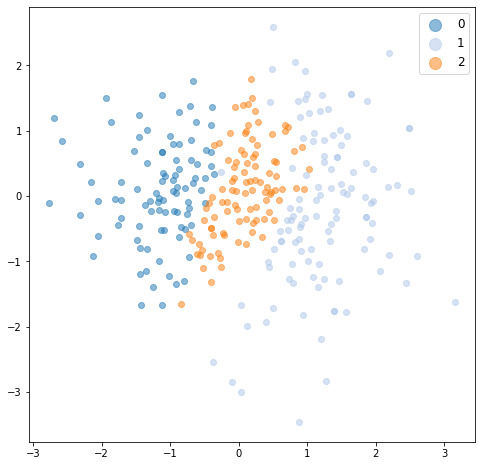

In [52]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import cm

cmap = cm.get_cmap('tab20')
fig, ax = plt.subplots(figsize=(8,8))
num_categories = 3
for lab in range(num_categories):
    indices = target==lab
    ax.scatter(z_[indices,0],z_[indices,1], c=np.array(cmap(lab)).reshape(1,4), label = lab ,alpha=0.5)
ax.legend(fontsize='large', markerscale=2)
plt.show()

# n_samples = 600
# semi-dual sgd

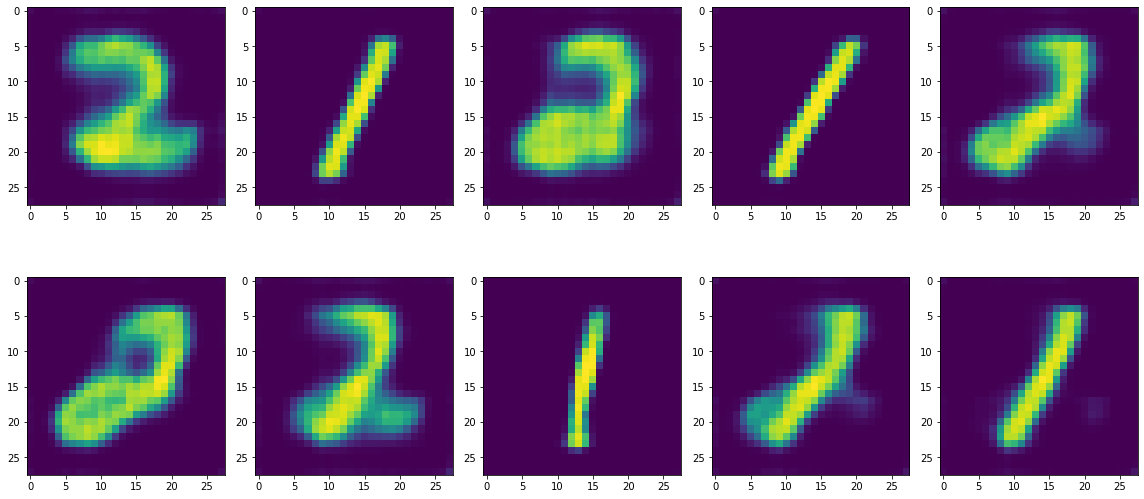

In [53]:
with torch.no_grad():
    dist = model.c_function(model.z)
fig, axs = plt.subplots(nrows=2, ncols=5, figsize=(16, 8))
img = dist.mean.numpy().transpose(0,2,3,1)[10:20]
n = 0
for ax in axs.flat:
    ax.imshow(img[n])
    n=n+1

plt.tight_layout()
plt.show()

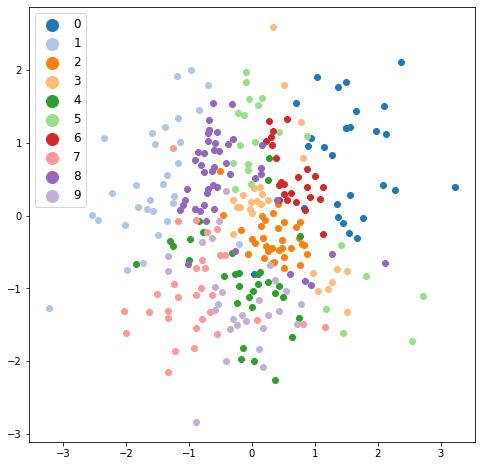

In [15]:
z_ = z_.cpu()

cmap = cm.get_cmap('tab20')
fig, ax = plt.subplots(figsize=(8,8))
num_categories = 10
for lab in range(num_categories):
    indices = target==lab
    ax.scatter(z_[indices,0],z_[indices,1], c=np.array(cmap(lab)).reshape(1,4), label = lab ,alpha=1)
ax.legend(fontsize='large', markerscale=2)
plt.show()

# n_samples = 600
# semi-dual sgd

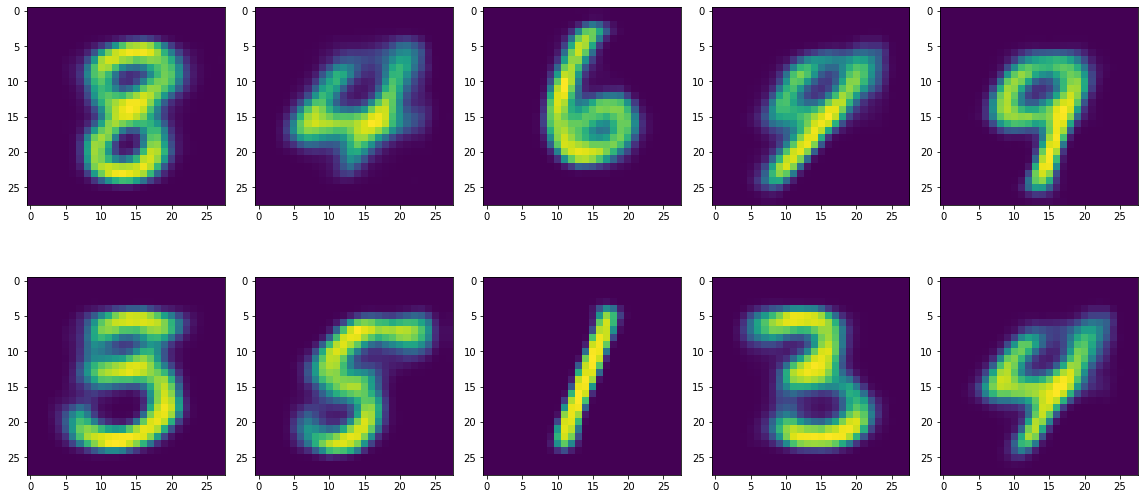

In [14]:


with torch.no_grad():
    dist = model.c_function(model.z)
fig, axs = plt.subplots(nrows=2, ncols=5, figsize=(16, 8))
img = dist.mean.cpu().numpy().transpose(0,2,3,1)[10:20]
n = 0
for ax in axs.flat:
    ax.imshow(img[n])
    n=n+1

plt.tight_layout()
plt.show()

In [3]:
import models
import torch
import dataset
from torch import nn
%load_ext autoreload
%autoreload 2

class config(object):
    def __init__(self, dataset, batch_size):
        self.dataset = dataset
        self.batch_size = batch_size
        self.data = './'
        
args = config('MNIST',256)


In [4]:
actif='lrelu'
cuda = torch.cuda.is_available()
device = torch.device("cuda" if cuda else "cpu")

activations_list = {
    'softplus': nn.Softplus(),
    'lrelu': nn.LeakyReLU(),
    'relu': nn.ReLU()
}
activFun = activations_list[actif]
train_loader, ts = dataset.get_loaders(args)

img_size = 28
epsilon = 1
in_channels =1
latent_class = 2
epochs = 20
n_samples = 2000

In [5]:
model = models.CoopCommSemiDual(n_samples, epsilon, in_channels, latent_class, activFun, img_size, device)
model.cuda()
optimizer = torch.optim.Adam(model.parameters(), lr=5e-4)


In [6]:
for epoch in range(1, epochs + 1):
    loss_sum = 0
    for batch_idx, (data, target) in enumerate(train_loader):
        data = data.to(device)
        optimizer.zero_grad()
        P, C, kl, z = model(data)
        loss = model.EotLoss(P, C, kl)
        loss.backward()        
        optimizer.step()
        with torch.no_grad():
            loss_sum += loss.item()
    print(f"Epoch: {epoch}, Loss: {loss_sum/len(train_loader)}")


RuntimeError: CUDA out of memory. Tried to allocate 1.50 GiB (GPU 0; 8.00 GiB total capacity; 4.50 GiB already allocated; 1.10 GiB free; 4.51 GiB reserved in total by PyTorch)

In [6]:
torch.save(model.state_dict(), './model.pt')


In [5]:
model.load_state_dict(torch.load('./model.pt'))
model.eval()

CoopCommSemiDual(
  (c_function): Decoder(
    (activation): LeakyReLU(negative_slope=0.01)
    (decoder_input): Sequential(
      (0): Linear(in_features=2, out_features=2048, bias=True)
      (1): LeakyReLU(negative_slope=0.01)
    )
    (decoder): Sequential(
      (0): Sequential(
        (0): ConvTranspose2d(128, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        (1): LeakyReLU(negative_slope=0.01)
      )
      (1): Sequential(
        (0): ConvTranspose2d(64, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
        (1): LeakyReLU(negative_slope=0.01)
      )
    )
    (final_layer): Sequential(
      (0): ConvTranspose2d(32, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
      (1): LeakyReLU(negative_slope=0.01)
      (2): Conv2d(32, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    )
  )
)

In [6]:
for batch_idx, (data, target) in enumerate(ts):
    print(batch_idx)


0


In [8]:
model.device = "cpu"
model.cpu()
model.eval()

with torch.no_grad():
    P, C, kl, z = model(data[:1000])

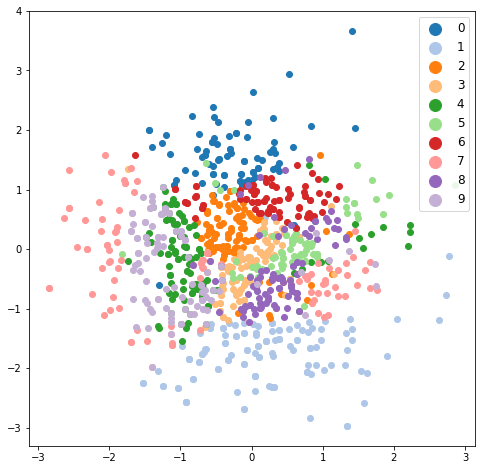

In [9]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import cm

z_ = z[P.argmax(axis=1)]
z_ = z_.cpu()

cmap = cm.get_cmap('tab20')
fig, ax = plt.subplots(figsize=(8,8))
num_categories = 10
for lab in range(num_categories):
    indices = target[:1000]==lab
    ax.scatter(z_[indices,0],z_[indices,1], c=np.array(cmap(lab)).reshape(1,4), label = lab ,alpha=1)
ax.legend(fontsize='large', markerscale=2)
plt.show()

# n_samples = 600
# semi-dual sgd

In [4]:
model2 = models.CoopCommSemiDual(n_samples, epsilon, in_channels, latent_class, activFun, img_size, device)
model2.load_state_dict(torch.load('./model.pt'))
model2.eval()

CoopCommSemiDual(
  (c_function): Decoder(
    (activation): LeakyReLU(negative_slope=0.01)
    (decoder_input): Sequential(
      (0): Linear(in_features=2, out_features=2048, bias=True)
      (1): LeakyReLU(negative_slope=0.01)
    )
    (decoder): Sequential(
      (0): Sequential(
        (0): ConvTranspose2d(128, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        (1): LeakyReLU(negative_slope=0.01)
      )
      (1): Sequential(
        (0): ConvTranspose2d(64, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
        (1): LeakyReLU(negative_slope=0.01)
      )
    )
    (final_layer): Sequential(
      (0): ConvTranspose2d(32, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
      (1): LeakyReLU(negative_slope=0.01)
      (2): Conv2d(32, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    )
  )
)

In [7]:
model2.device = "cpu"
model2.cpu()
model2.eval()

with torch.no_grad():
    P, C, kl, z = model2(data[:1000])

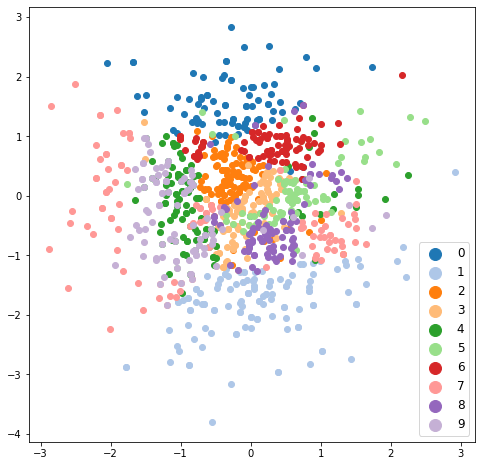

In [8]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import cm

z_ = z[P.argmax(axis=1)]
z_ = z_.cpu()

cmap = cm.get_cmap('tab20')
fig, ax = plt.subplots(figsize=(8,8))
num_categories = 10
for lab in range(num_categories):
    indices = target[:1000]==lab
    ax.scatter(z_[indices,0],z_[indices,1], c=np.array(cmap(lab)).reshape(1,4), label = lab ,alpha=1)
ax.legend(fontsize='large', markerscale=2)
plt.show()

# n_samples = 600
# semi-dual sgd

In [19]:
torch.topk(P[0],5)

torch.return_types.topk(
values=tensor([5.2334e-04, 2.4299e-04, 2.3367e-04, 1.0298e-09, 1.4317e-11],
       dtype=torch.float64),
indices=tensor([624, 953, 202, 677, 830]))

In [12]:
torch.cuda.max_memory_allocated()

4826789376

In [18]:
import numpy as np
import ot

In [28]:
a = [.5, .5]
b = [.5, .5]
M = [[0., 1.], [1., 0.]]
P = ot.sinkhorn(a, b, M, 100)
loss = ot.sinkhorn2(a, b, M, 100)

In [29]:
C = np.array(M)

In [30]:
(P*C).sum()

0.497500020833125

In [31]:
loss

0.497500020833125

In [32]:
P

array([[0.25124999, 0.24875001],
       [0.24875001, 0.25124999]])